In [35]:
import zipfile
import pandas as pd
import numpy as np
import os
import shutil
from textwrap import wrap
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import layers, callbacks
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
from keras.layers import *
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Swapnali
[nltk_data]     singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Swapnali
[nltk_data]     singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Swapnali
[nltk_data]     singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#unzipping the file
extract_dir = 'DL_flikr'
with zipfile.ZipFile('flickr30k-images.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['flickr30k-images', '__MACOSX']


In [3]:
dfcsv = 'flickr_annotations_30k.csv'
df = pd.read_csv(dfcsv)

In [4]:
output_folder_train = "Flikr/Flikr_train"
os.makedirs(output_folder_train, exist_ok=True)

In [5]:
#to store for training and validation both
nt_images = 3200
# Counter for storing images for training and validation both
st_images = 0

In [6]:
#dataframe to store train
df1 = pd.DataFrame(columns=["image", "caption"])

In [7]:
imagesf = 'DL_flikr/flickr30k-images'
all_images = os.listdir(imagesf)

In [8]:
for filename in all_images:
    # Check if the image details exists in the Excel file
    if filename in df['filename'].values:
        # Getting the corresponding row 
        row = df[df['filename'] == filename].iloc[0]
        # image caption
        caption = row["raw"]
        
        # to store in train and validation set
        if st_images < nt_images:
            output_folder = output_folder_train
            st_images += 1
            # Append filename and caption to the DataFrame train
            df1 = df1.append({"image": filename, "caption": caption}, ignore_index=True)
        else:
            break
        
        # Copy image to output folder
        shutil.copy(os.path.join(imagesf, filename), os.path.join(output_folder, filename))
        
print("Images stored successfully.")

Images stored successfully.


In [9]:
df1.head()

,image,caption
0,1000092795.jpg,"[""Two young guys with shaggy hair look at thei..."
1,10002456.jpg,"[""Several men in hard hats are operating a gia..."
2,1000268201.jpg,"[""A child in a pink dress is climbing up a set..."
3,1000344755.jpg,"[""Someone in a blue shirt and hat is standing ..."
4,1000366164.jpg,"[""Two men, one in a gray shirt, one in a black..."


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    3200 non-null   object
 1   caption  3200 non-null   object
dtypes: object(2)
memory usage: 50.1+ KB


In [11]:
df1.isnull().sum()

image      0
caption    0
dtype: int64

In [12]:
#to read image in one format
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    
    img = img_to_array(img)
    img = img/255.
    
    return img

In [13]:
def display_train_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(5):
        n+=1
        plt.subplot(1 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image_path = f"Flikr/Flikr_train/{temp_df.image[i]}"
        print("Image Path:", image_path)
        image = readImage(image_path)
        
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

Image Path: Flikr/Flikr_train/1164131282.jpg
Image Path: Flikr/Flikr_train/170550385.jpg
Image Path: Flikr/Flikr_train/1094606832.jpg
Image Path: Flikr/Flikr_train/131254736.jpg
Image Path: Flikr/Flikr_train/1253264731.jpg


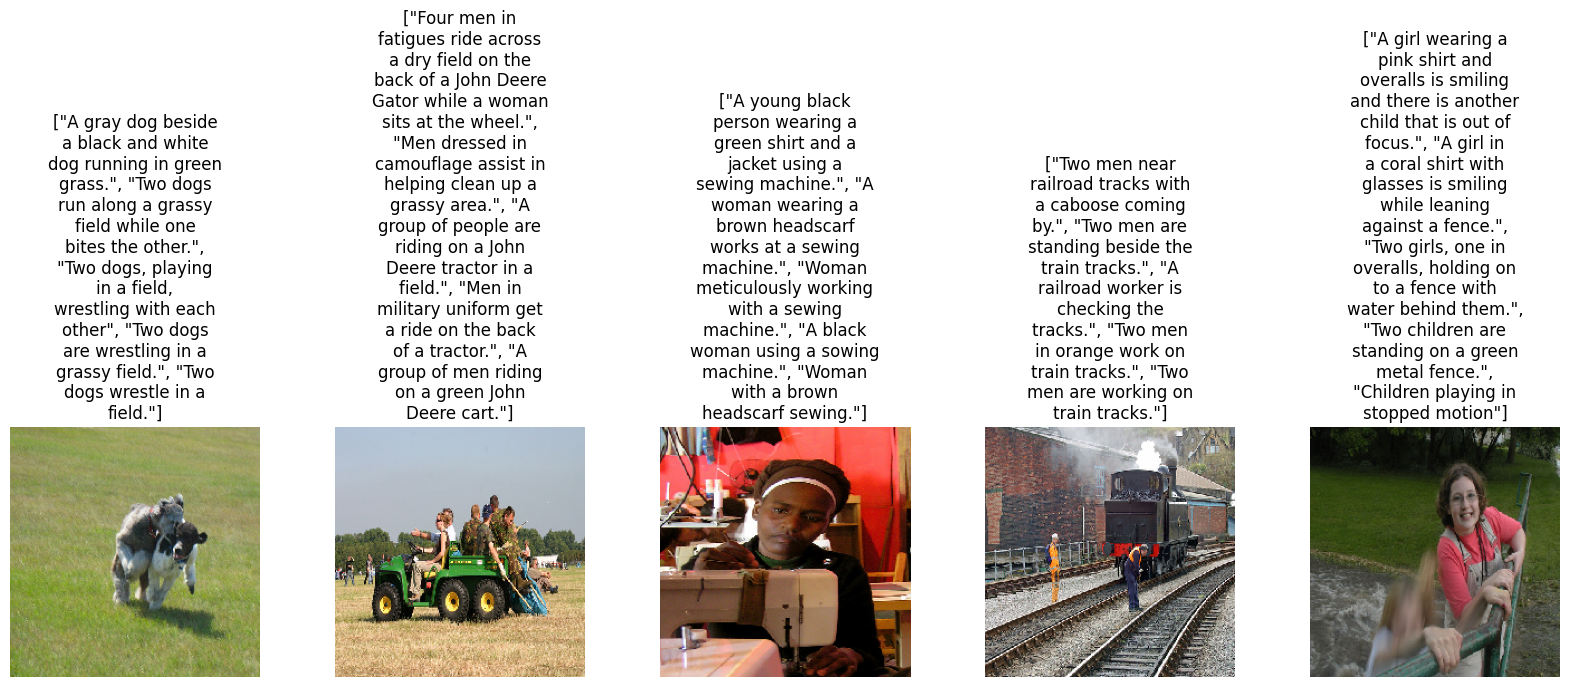

In [14]:
display_train_images(df1.sample(5))

In [15]:
import json
df1['caption'] = df1['caption'].apply(lambda x: json.loads(x))

# Create new columns with the split sentences
dft = df1['caption'].apply(lambda x: pd.Series(x))
dft.columns = [f"caption_{i+1}" for i in range(dft.shape[1])]

In [16]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   caption_1  3200 non-null   object
 1   caption_2  3200 non-null   object
 2   caption_3  3200 non-null   object
 3   caption_4  3200 non-null   object
 4   caption_5  3200 non-null   object
dtypes: object(5)
memory usage: 125.1+ KB


In [17]:
dfn = pd.concat([dft['caption_2'], df1['image']], axis=1)
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   caption_2  3200 non-null   object
 1   image      3200 non-null   object
dtypes: object(2)
memory usage: 50.1+ KB


In [19]:
def text_preprocessing(data):
    data['caption_2'] = data['caption_2'].apply(lambda x: x.lower())
    data['caption_2'] = data['caption_2'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption_2'] = data['caption_2'].apply(lambda x: x.replace("\s+"," "))
    data['caption_2'] = data['caption_2'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption_2'] = "startseq "+data['caption_2']+" endseq"
    return data

In [20]:
dft1 = text_preprocessing(dfn)
captions = dft1['caption_2'].tolist()
captions[:10]

['startseq two young, white males are outside near many bushes. endseq',
 'startseq workers look down from up above on piece of equipment. endseq',
 'startseq little girl in pink dress going into wooden cabin. endseq',
 'startseq man in blue shirt is standing on ladder cleaning window. endseq',
 'startseq two guy cooking and joking around with the camera. endseq',
 'startseq man in green holds guitar while the other man observes his shirt. endseq',
 'startseq man is sitting on chair holding large stuffed animal. endseq',
 'startseq trendy girl talking on her cellphone while gliding slowly down the street. endseq',
 'startseq three people are standing outside near large pipes and metal railing. endseq',
 'startseq two youths are jumping over roadside railing, at night. endseq']

In [21]:
dft1.head()

,caption_2,image
0,"startseq two young, white males are outside ne...",1000092795.jpg
1,startseq workers look down from up above on pi...,10002456.jpg
2,startseq little girl in pink dress going into ...,1000268201.jpg
3,startseq man in blue shirt is standing on ladd...,1000344755.jpg
4,startseq two guy cooking and joking around wit...,1000366164.jpg


In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

In [23]:
images = dft1['image'].unique().tolist()
nimages = len(images)

In [24]:
split_index = round(0.80*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = dft1[dft1['image'].isin(train_images)]
test = dft1[dft1['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 158, 196, 35, 61, 39, 360, 6, 218, 9, 442, 2]

In [25]:
dft1['caption']=dft1['caption_2']
dft1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   caption_2  3200 non-null   object
 1   image      3200 non-null   object
 2   caption    3200 non-null   object
dtypes: object(3)
memory usage: 75.1+ KB


In [26]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
image_path = 'Flikr/Flikr_train'
img_size = 224
features = {}
for image in tqdm(dfn['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████████████████████████████████████████████████████████████████████████| 3200/3200 [25:32<00:00,  2.09it/s]


In [36]:
class DataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [37]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input1,input2], outputs=output)
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          491776      ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 256)       0           ['dense_3[0][0]']                
                                                                                            

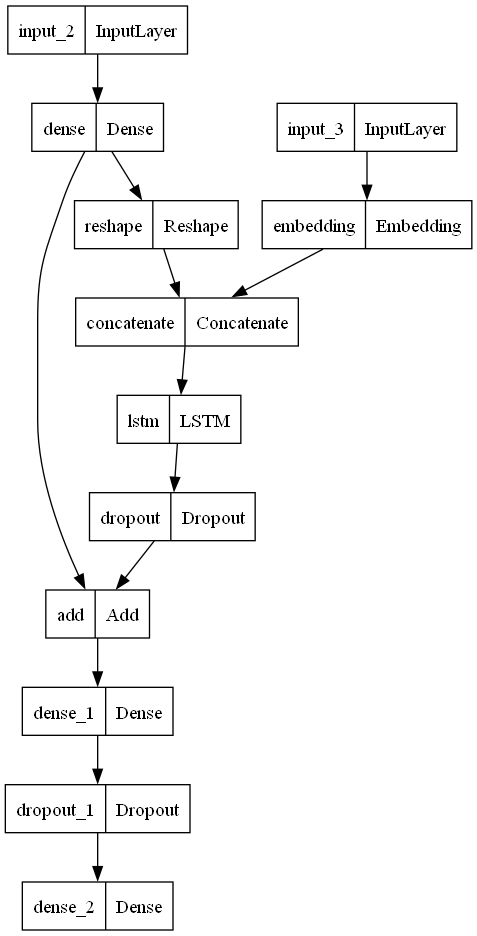

In [30]:
plot_model(model)

In [31]:
dfntrain = dft1.iloc[:split_index]  # Training set (80%)
dfntest = dft1.iloc[split_index:]    # Testing set (20%)

# Print the training and testing DataFrames
print("Training Set:")
print(dfntrain)

print("\nTesting Set:")
print(dfntest)

Training Set:
                                              caption_2           image  \
0     startseq two young, white males are outside ne...  1000092795.jpg   
1     startseq workers look down from up above on pi...    10002456.jpg   
2     startseq little girl in pink dress going into ...  1000268201.jpg   
3     startseq man in blue shirt is standing on ladd...  1000344755.jpg   
4     startseq two guy cooking and joking around wit...  1000366164.jpg   
...                                                 ...             ...   
2555  startseq two people are running from something...  1855937878.jpg   
2556  startseq man holding walkie talkie in front of...  1855985590.jpg   
2557  startseq young mormon man walking with his bik...  1857399990.jpg   
2558  startseq blond-haired man dressed in dark colo...  1857479783.jpg   
2559  startseq three men dig through construction si...  1858123511.jpg   

                                                caption  
0     startseq two young, w

In [39]:

image_path = 'Flikr/Flikr_train'
train_generator = DataGenerator(df=dfntrain,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)
image_path = 'Flikr/Flikr_train'
validation_generator = DataGenerator(df=dfntest,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [40]:
model_name = "cnnlstm_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [41]:
history = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 6.5878
Epoch 1: val_loss improved from inf to 6.00577, saving model to cnnlstm_model.h5
40/40 [==============================] - 75s 2s/step - loss: 6.5878 - val_loss: 6.0058 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 5.9109
Epoch 2: val_loss improved from 6.00577 to 5.82621, saving model to cnnlstm_model.h5
40/40 [==============================] - 70s 2s/step - loss: 5.9109 - val_loss: 5.8262 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 5.6847
Epoch 3: val_loss improved from 5.82621 to 5.64087, saving model to cnnlstm_model.h5
40/40 [==============================] - 69s 2s/step - loss: 5.6847 - val_loss: 5.6409 - lr: 0.0010
Epoch 4/30
40/40 [==============================] - ETA: 0s - loss: 5.4453
Epoch 4: val_loss improved from 5.64087 to 5.49811, saving model to cnnlstm_model.h5
40/40 [==============================] - 69s 2s/step - loss: 5.4

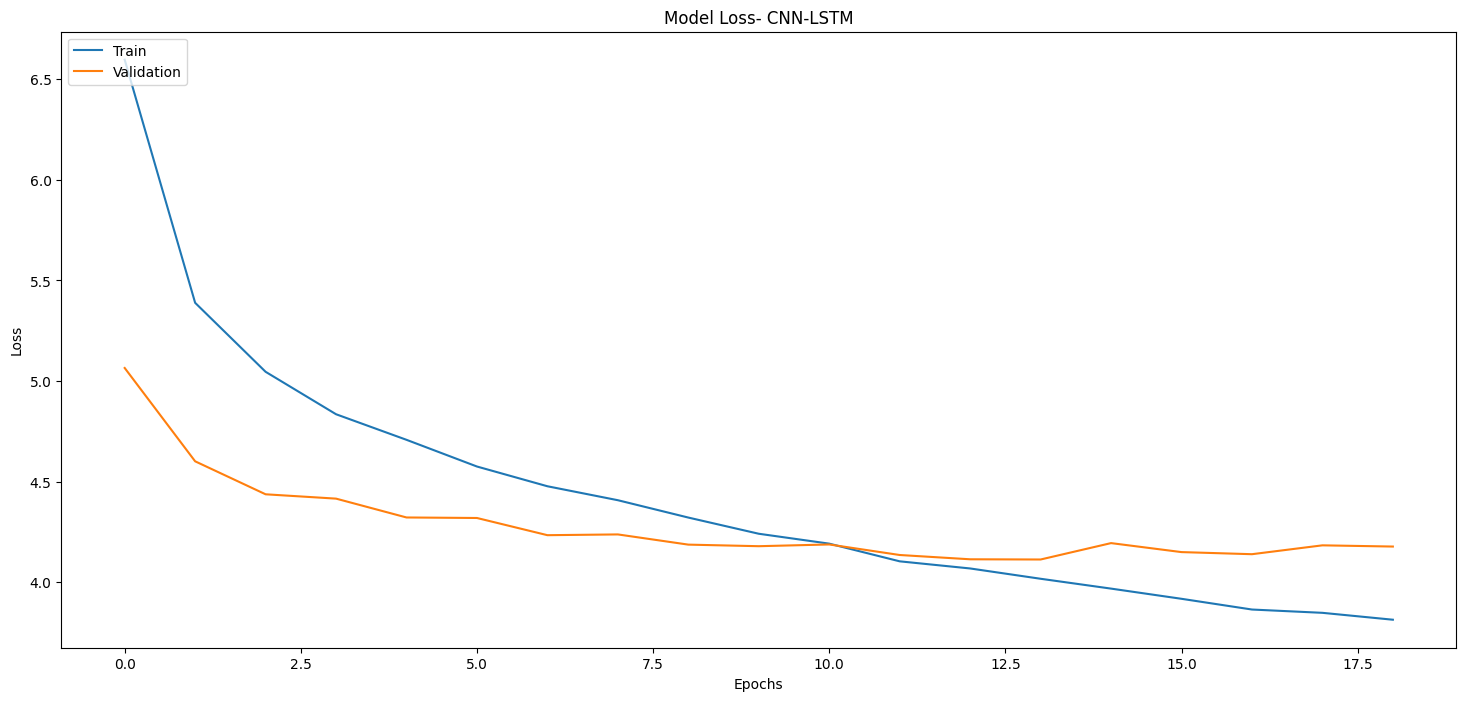

In [191]:
plt.figure(figsize=(18,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss- CNN-LSTM')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [43]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [44]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [45]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 31ms/step


Image Path: Flikr/Flikr_train/157613268.jpg
Image Path: Flikr/Flikr_train/1547575241.jpg
Image Path: Flikr/Flikr_train/1499554025.jpg
Image Path: Flikr/Flikr_train/1509274237.jpg
Image Path: Flikr/Flikr_train/1578355853.jpg


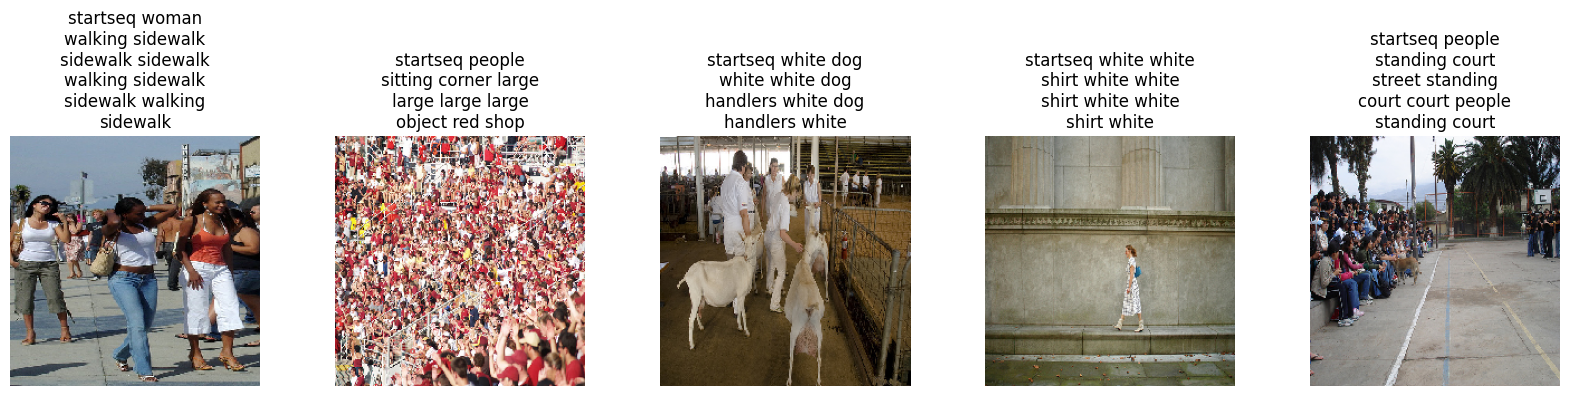

In [196]:
display_train_images(samples)

Image Path: Flikr/Flikr_train/19663315.jpg
Image Path: Flikr/Flikr_train/2050742372.jpg
Image Path: Flikr/Flikr_train/1873655403.jpg
Image Path: Flikr/Flikr_train/2068403258.jpg
Image Path: Flikr/Flikr_train/2072268965.jpg


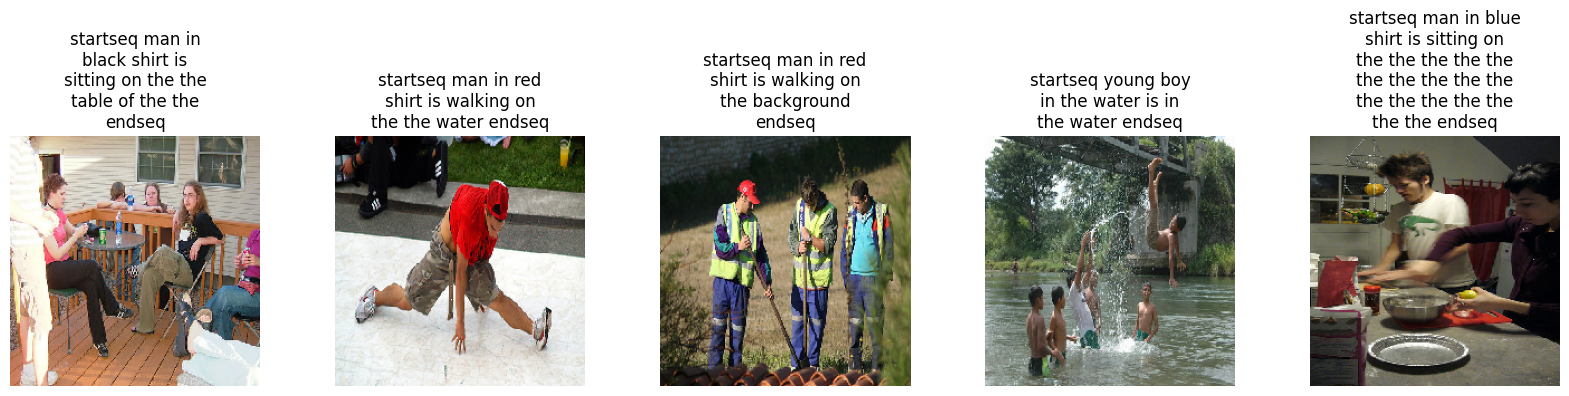

In [47]:
display_train_images(samples)